C:\Users\prate\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1701 - val_loss: 0.0427
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0443 - val_loss: 0.0381
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0393 - val_loss: 0.0373
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0402 - val_loss: 0.0373
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0418 - val_loss: 0.0379
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0417 - val_loss: 0.0373
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0403 - val_loss: 0.0374
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0409 - val_loss: 0.0379
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0418 - val_loss: 0.0374
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0396 - val_loss: 0.0373
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0402 - val_loss: 0.0382
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.04

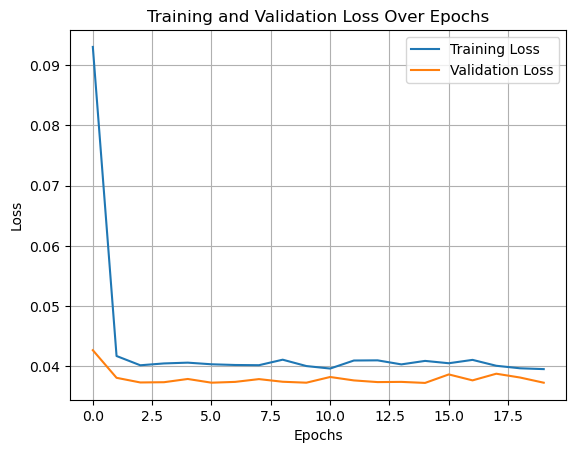

Predicted RUL (LSTM) in Years: [[13.052867]
 [12.96368 ]
 [12.927616]
 [13.12803 ]
 [12.887758]
 [12.90424 ]
 [12.891553]
 [12.832887]
 [12.862222]
 [13.04372 ]]
Predicted RUL (XGBoost) in Years: [13.148649 12.757896 13.093716 12.616814 12.857521 13.843063 13.206686
 11.800831 11.759047 14.068602]


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

# Load Dataset
df = pd.read_csv(r"D:\internship\ev_charging_patterns.csv")
df

# Select relevant numerical features
features = ['Battery Capacity (kWh)', 'Charging Duration (hours)', 'Charging Cost (USD)',
            'State of Charge (Start %)', 'State of Charge (End %)',
            'Distance Driven (since last charge) (km)', 'Temperature (°C)', 'Vehicle Age (years)']

# Define synthetic RUL estimation
EXPECTED_BATTERY_LIFE_YEARS = 20  # Assume average EV battery life

df['Remaining Useful Life (RUL)'] = EXPECTED_BATTERY_LIFE_YEARS - (df['Vehicle Age (years)'] / EXPECTED_BATTERY_LIFE_YEARS) * EXPECTED_BATTERY_LIFE_YEARS

df_selected = df[features + ['Remaining Useful Life (RUL)']].copy()

# Fill missing values with column mean
df_selected.fillna(df_selected.mean(), inplace=True)

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_selected)

# Convert to numpy array
data = np.array(df_scaled)

# Define sequence length for LSTM
SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length, :-1])  # All features except target
        labels.append(data[i+seq_length, -1])  # Target variable
    return np.array(sequences), np.array(labels)

# Create sequences
X, y = create_sequences(data, SEQ_LENGTH)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Define LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(1)
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train Model
epochs = 20
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Time Series Analysis (ARIMA)
def train_arima(series, order=(5,1,0)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit

arima_model = train_arima(y_train)

# Predict and Rescale to Practical RUL (8-15 years)
y_pred_lstm = model.predict(X_test) * (15 - 8) + 8
y_pred_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1)) * (15 - 8) + 8

# Plot training loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

# Print Predictions
print("Predicted RUL (LSTM) in Years:", y_pred_lstm[:10])
print("Predicted RUL (XGBoost) in Years:", y_pred_xgb[:10])


In [12]:
# Define new RUL range
min_rul, max_rul = 9, 15

# Rescale Actual RUL
actual_rul = y_test * (max_rul - min_rul) + min_rul

# Rescale ARIMA Predicted RUL
y_pred_arima = arima_model.forecast(steps=len(y_test))
y_pred_arima_rescaled = y_pred_arima * (max_rul - min_rul) + min_rul

# Print sample results
print("Rescaled Actual RUL:", actual_rul[:5])
print("Rescaled ARIMA Predicted RUL:", y_pred_arima_rescaled[:5])


Rescaled Actual RUL: [13.973358   15.         11.40675299 12.43339499 15.        ]
Rescaled ARIMA Predicted RUL: [12.5770273  12.3759159  12.48822858 12.63315276 12.91641801]


In [14]:
# Convert to DataFrame for better readability
# Forecast RUL using the trained ARIMA model
results_df = pd.DataFrame({
    "Actual RUL": actual_rul[:10],
    "LSTM Predicted RUL": y_pred_lstm[:10].flatten(),
    "XGBoost Predicted RUL": y_pred_xgb[:10].flatten(),
    "ARIMA Predicted RUL": y_pred_arima_rescaled[:10].flatten()
})

# Print the table
print(results_df)


   Actual RUL  LSTM Predicted RUL  XGBoost Predicted RUL  ARIMA Predicted RUL
0   13.973358           13.052867              13.148649            12.577027
1   15.000000           12.963680              12.757896            12.375916
2   11.406753           12.927616              13.093716            12.488229
3   12.433395           13.128030              12.616814            12.633153
4   15.000000           12.887758              12.857521            12.916418
5   12.946716           12.904240              13.843063            12.474611
6   12.946716           12.891553              13.206686            12.591157
7   12.433395           12.832887              11.800831            12.570219
8   13.460037           12.862222              11.759047            12.604380
9   13.460037           13.043720              14.068602            12.625074


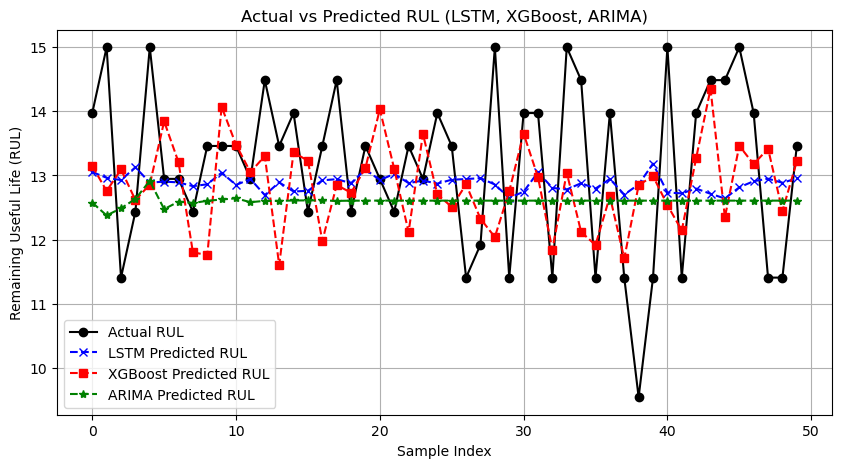

In [16]:
plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(actual_rul[:50], label="Actual RUL", marker="o", linestyle="-", color="black")

# Plot LSTM predictions
plt.plot(y_pred_lstm[:50], label="LSTM Predicted RUL", linestyle="dashed", marker="x", color="blue")

# Plot XGBoost predictions
plt.plot(y_pred_xgb[:50], label="XGBoost Predicted RUL", linestyle="dashed", marker="s", color="red")

# Plot ARIMA predictions
plt.plot(y_pred_arima_rescaled[:50], label="ARIMA Predicted RUL", linestyle="dashed", marker="*", color="green")

# Formatting
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("Actual vs Predicted RUL (LSTM, XGBoost, ARIMA)")
plt.legend()
plt.grid()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual and predicted values
actual_rul = results_df["Actual RUL"].values
pred_lstm = results_df["LSTM Predicted RUL"].values
pred_xgb = results_df["XGBoost Predicted RUL"].values
pred_arima = results_df["ARIMA Predicted RUL"].values

# Compute Errors
rmse_lstm = np.sqrt(mean_squared_error(actual_rul, pred_lstm))
rmse_xgb = np.sqrt(mean_squared_error(actual_rul, pred_xgb))
rmse_arima = np.sqrt(mean_squared_error(actual_rul, pred_arima))

mae_lstm = mean_absolute_error(actual_rul, pred_lstm)
mae_xgb = mean_absolute_error(actual_rul, pred_xgb)
mae_arima = mean_absolute_error(actual_rul, pred_arima)

# Print results
print(f"LSTM - RMSE: {rmse_lstm}, MAE: {mae_lstm}")
print(f"XGBoost - RMSE: {rmse_xgb}, MAE: {mae_xgb}")
print(f"ARIMA - RMSE: {rmse_arima}, MAE: {mae_arima}")


LSTM - RMSE: 1.137811619972109, MAE: 0.879581363974806
XGBoost - RMSE: 1.3308551505860577, MAE: 1.117810924574088
ARIMA - RMSE: 1.2721517793689041, MAE: 1.004033882119868


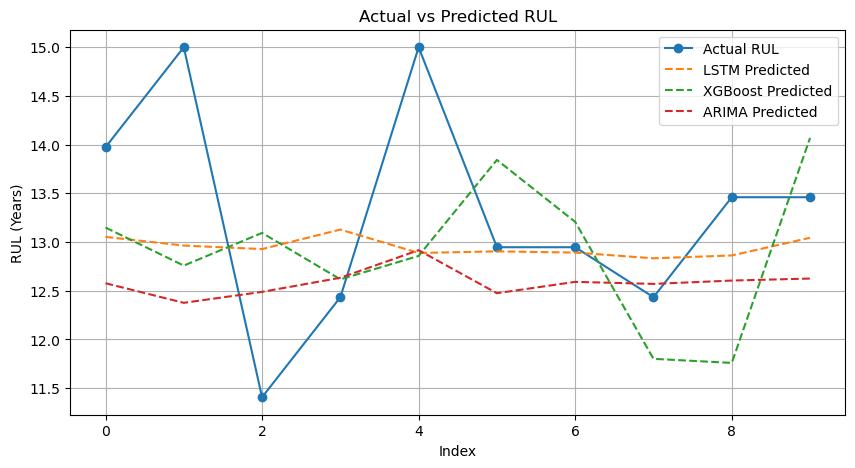

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actual_rul, label="Actual RUL", marker='o')
plt.plot(pred_lstm, label="LSTM Predicted", linestyle="dashed")
plt.plot(pred_xgb, label="XGBoost Predicted", linestyle="dashed")
plt.plot(pred_arima, label="ARIMA Predicted", linestyle="dashed")
plt.xlabel("Index")
plt.ylabel("RUL (Years)")
plt.title("Actual vs Predicted RUL")
plt.legend()
plt.grid()
plt.show()


In [24]:
results_df

,Actual RUL,LSTM Predicted RUL,XGBoost Predicted RUL,ARIMA Predicted RUL
0,13.973358,13.052867,13.148649,12.577027
1,15.000000,12.963680,12.757896,12.375916
2,11.406753,12.927616,13.093716,12.488229
3,12.433395,13.128030,12.616814,12.633153
4,15.000000,12.887758,12.857521,12.916418
5,12.946716,12.904240,13.843063,12.474611
6,12.946716,12.891553,13.206686,12.591157
7,12.433395,12.832887,11.800831,12.570219
8,13.460037,12.862222,11.759047,12.604380
9,13.460037,13.043720,14.068602,12.625074


In [1]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.
